# Process Band output from single band to projected band data
The output from a single band simulation with varied out-of-plane component $k_z$ contains results from different simulations. Previously, the variation of $k_z$ was done by computing band diagrams for each $k_z$ value separetely simply by controling multiple computations via a python script. The number of files was the same as the number of $k_z$ values which makes the directories unclear. 

To overcome this file load the control script for computing the bands inlcudes the variation of $k_z$. All bands are stored in a single file. 

The output from one band computation contains two important sections. The first one outputs the frequencies of each band at a specific k component:
```
freqs:, 1, 0, 0, 1, 1, 0.713283, 0.71331, 1.04852, 1.04853, 1.04899, 1.05195, 1.06541, 1.06546  
zparity:, 1, -0.962869800704686, 0.988717569927763, -0.393725830204545, -0.395734569771763, -0.998887410516107, 0.999650502195148, -0.347248048116146, -0.34777548079696
yparity:, 1, 0.975790905686622, -0.97574562896145, -0.0582955864701207, 0.595574298741082, 1.18512674518712e-4, 5.39731885476151e-5, -3.29535405058144e-4, 3.40133434347039e-4 
```
Each line starting with `freqs:` has the following format:
```
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
```
Of course, the number of columns depends on the number of computed bands.

The parity has only the `k index` as additional column, so empty cells have to be inserted to correct the position of the parity values for the accoring band.

The second section contains the frequency range of each band and looks like the following:
```
Band 1 range: 0.713282699590462 at #(0 0 1.0) to 0.830264439877785 at #(-1/3 1/3 1.0)                                   
Band 2 range: 0.713310166811443 at #(0 0 1.0) to 0.831994097275396 at #(-1/3 1/3 1.0)                                   
Band 3 range: 0.828008821781271 at #(0 0.5 1.0) to 1.04852248948853 at #(0 0 1.0)                                       
Band 4 range: 0.847539035928083 at #(0 0.5 1.0) to 1.04852795602003 at #(0 0 1.0)                                       
Band 5 range: 0.899871227847482 at #(-1/3 1/3 1.0) to 1.05032421437858 at #(0 0.0500000000000001 1.0)                   
Band 6 range: 0.89993234948052 at #(-1/3 1/3 1.0) to 1.05453763661395 at #(0 0.0500000000000001 1.0)                    
Band 7 range: 1.01218332078481 at #(0 0.5 1.0) to 1.16912569096451 at #(-1/3 1/3 1.0)                                   
Band 8 range: 1.04206232874704 at #(0 0.5 1.0) to 1.17121580880774 at #(-1/3 1/3 1.0)  
```

In [207]:
import pandas as pd
# import os.path
# import numpy as np
import re
# # import fnmatch
# import glob
# from libprocessing import *
import numpy as np
import os

from libanalysis import * 
%matplotlib notebook

In [208]:
%load_ext autoreload
%autoreload 2

In [195]:
path_to_file="../Simulation-results/MPB/Lin-structure/test_0.0_1.0.out"

('../Simulation-results/MPB/Lin-structure/test_0.0_1.0', '.out')

In [36]:
with open(path_to_file, "r") as sim_f:
    data_lines= np.array([s for s in sim_f.readlines() if re.search("freqs:|zparity:|yparity:|Band [0-9] range|Band [0-9][0-9] range", s)])

header_rows_selector= np.vectorize(lambda s: bool(re.search("freqs:, k index", s)) )    

header_rows = [i for i,b in enumerate( header_rows_selector(data_lines) ) if b ]


In [205]:

def export_freq_data_to_h5(path_to_file):
    with open(path_to_file, "r") as sim_f:
        data_lines= np.array([s for s in sim_f.readlines() if re.search("freqs:", s)])

    band_labels=data_lines[0].replace("\n","").split(",")[6:]

    header_rows_selector= np.vectorize(lambda s: bool(re.search("freqs:, k index", s)) )    
    header_rows = [i for i,b in enumerate( header_rows_selector(data_lines) ) if b ]

    file_content_varied_kz = np.array([line.replace("\n","").split(",") for line in np.delete(data_lines, header_rows)])

    # multiindex= 
    df=pd.DataFrame(file_content_varied_kz[:,6:].astype(float),  index=[file_content_varied_kz[:, 4 ].astype(float),
     file_content_varied_kz[:, 1 ].astype(int) ], columns= band_labels,
         )
    df.index.names=["kz","kt"]
    
    df.to_hdf(os.path.splitext(path_to_file)[0]+ ".h5" , "df")
    

In [206]:
export_freq_data_to_h5(path_to_file)

<IPython.core.display.Javascript object>


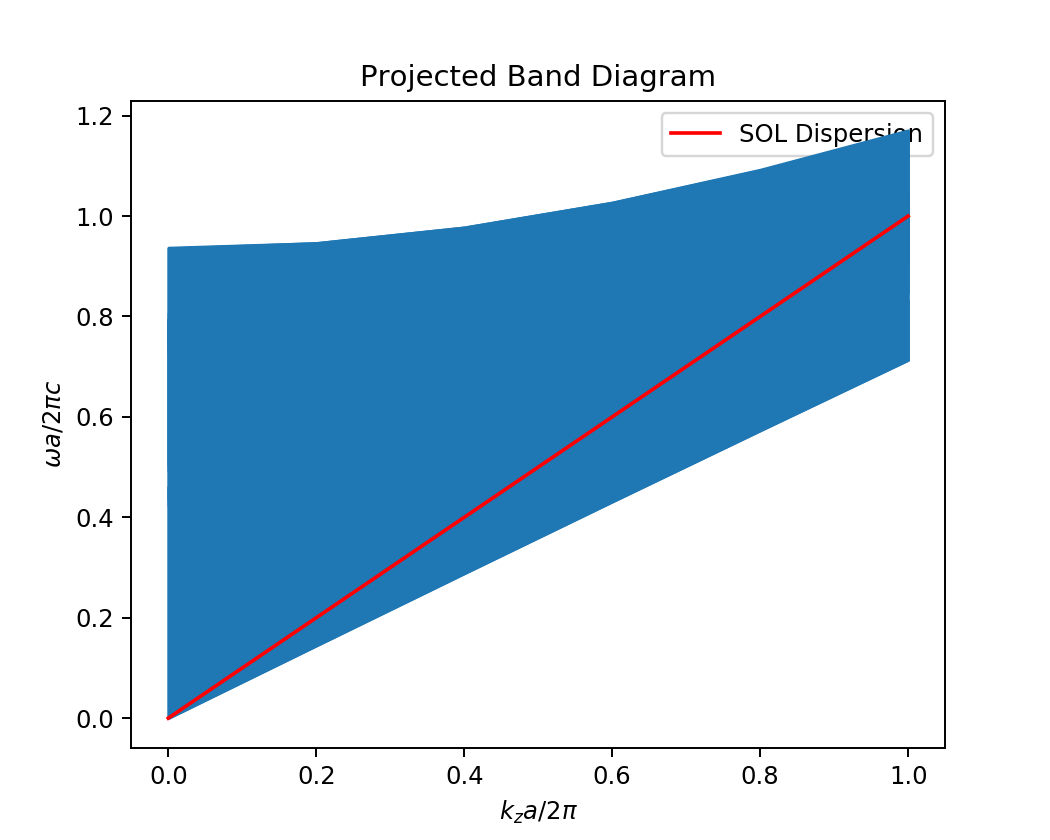

In [209]:
ax_6=plot_projected_bands_from_h5("../Simulation-results/MPB/Lin-structure/test_0.0_1.0.h5")

In [103]:
def process_single_band_diagram_data(string_data_array):
    '''
    string_data_array: numpy array of dtype 'string'
    '''
    file_content_varied_kz = [line.replace("\n","") for line in string_data_array if not re.search("Band [0-9] range", line)]
    file_content_varied_kz = [line.replace(":,",":,,,,,").split(",") if bool(re.search("parity:", line)) else line.split(",") for line in file_content_varied_kz]
    band_labels= file_content_varied_kz[0][1:]
#     print(band_labels)
    file_str_array = np.array(file_content_varied_kz)
#     print(file_str_array.shape)
    labels=file_str_array[1:4,0]
#     data_from_varied_kz=np.delete(file_str_array[:,1:], slice(0,-1,5), axis=0)
    data_from_varied_kz=file_str_array[1:,1:]
    print(data_from_varied_kz[:9, :6])
    k_z_arr=data_from_varied_kz[::3,3].astype(float)
    assert(k_z_arr[0]==k_z_arr[-1])
    print(data_from_varied_kz[:,5:])
    print(np.arange(len(k_z_arr)))
#     df= pd.DataFrame(data= , index=np.arange(len(k_z_arr)), columns= band_labels)
    return k_z_arr[0], df
    
process_single_band_diagram_data(data_lines[0:102])

[[' 1' ' 0' ' 0' ' 0' ' 0' ' 0']
 ['' '' '' '' ' 1' ' 1.0']
 ['' '' '' '' ' 1' ' -1.0']
 [' 2' ' 0' ' 0.05' ' 0' ' 0.057735' ' 0.041179']
 ['' '' '' '' ' 2' ' -1.00000000000014']
 ['' '' '' '' ' 2' ' 0.999984669474488']
 [' 3' ' 0' ' 0.1' ' 0' ' 0.11547' ' 0.0823495']
 ['' '' '' '' ' 3' ' -0.999999999999999']
 ['' '' '' '' ' 3' ' 0.999936515603679']]
[[' 0' ' 0' ' 0.791487' ' 0.79425' ' 0.794258' ' 0.795479' ' 0.813455'
  ' 0.813474']
 [' 1.0' ' -1.0' ' -0.999999754908841' ' -0.99999988083734'
  ' -0.999999799685614' ' 0.999999289980049' ' 0.999997385729276'
  ' 0.999998085244584']
 [' -1.0' ' 1.0' ' 7.30982057897444e-4' ' 0.353405618559161'
  ' 0.999695849241118' ' 5.97548733194707e-5' ' -0.996850943716376'
  ' -0.405236874675697']
 [' 0.041179' ' 0.0416902' ' 0.761381' ' 0.774073' ' 0.784686' ' 0.806535'
  ' 0.80752' ' 0.808758']
 [' -1.00000000000014' ' 0.999999999999946' ' -0.99999999994916'
  ' 0.999999999957892' ' -0.999999999825242' ' -0.999999999995062'
  ' 0.999999999981347' '

(0.0,
            band 1    band 2    band 3    band 4    band 5    band 6    band 7  \
 kz   kt                                                                         
 0.00 0   0.000000  0.000000  0.785638  0.893750  0.893791  0.893924  0.990957   
      1   0.048660  0.053030  0.779520  0.887980  0.892094  0.898239  0.985317   
      2   0.097197  0.106029  0.763591  0.871281  0.887448  0.908295  0.971847   
      3   0.145474  0.158965  0.741582  0.845464  0.880692  0.917139  0.955657   
      4   0.193321  0.211797  0.715581  0.811722  0.872861  0.917859  0.939542   
      5   0.240496  0.264471  0.686491  0.771724  0.864886  0.908790  0.922774   
      6   0.286618  0.316899  0.654869  0.727477  0.857508  0.895201  0.908930   
      7   0.330982  0.368924  0.621516  0.680666  0.851273  0.882083  0.898657   
      8   0.372022  0.420149  0.588142  0.632650  0.846568  0.871855  0.891550   
      9   0.405501  0.468990  0.559166  0.585555  0.843649  0.865488  0.887366   
      10  

In [211]:
1/5

0.2